In [1]:
#libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
data1 = pd.read_csv('C:/Data_Science/Personal_Notebooks/Fertilizer_classification/train.csv')
data2 = pd.read_csv('C:/Data_Science/Personal_Notebooks/Fertilizer_classification/test.csv')

train_df = data1.copy()
test_df = data2.copy()

print("First 3 rows of train_df: \n", train_df.head(3))
print("First 3 rows of test_df: \n", test_df.head(3))

First 3 rows of train_df: 
    id  Temparature  Humidity  Moisture Soil Type  Crop Type  Nitrogen  \
0   0           37        70        36    Clayey  Sugarcane        36   
1   1           27        69        65     Sandy    Millets        30   
2   2           29        63        32     Sandy    Millets        24   

   Potassium  Phosphorous Fertilizer Name  
0          4            5           28-28  
1          6           18           28-28  
2         12           16        17-17-17  
First 3 rows of test_df: 
        id  Temparature  Humidity  Moisture Soil Type    Crop Type  Nitrogen  \
0  750000           31        70        52     Sandy        Wheat        34   
1  750001           27        62        45       Red    Sugarcane        30   
2  750002           28        72        28    Clayey  Ground Nuts        14   

   Potassium  Phosphorous  
0         11           24  
1         14           15  
2         15            4  


In [3]:
#function to make the columns snake_case
import re

def to_snake_case(df):
    def convert(name):
        #lower case
        name = name.lower()
        # Replace spaces and hyphens with underscores
        name = re.sub(r'[\s\-]+', '_', name)
        # Add underscore before capital letters (except at the beginning)
        name = re.sub(r'(?<!^)(?=[A-Z])', '_', name)
        # Convert to lowercase
        return name.lower()

    df.columns = [convert(col) for col in df.columns]
    return df

In [4]:
to_snake_case(train_df)
to_snake_case(test_df)

,id,temparature,humidity,moisture,soil_type,crop_type,nitrogen,potassium,phosphorous
0,750000,31,70,52,Sandy,Wheat,34,11,24
1,750001,27,62,45,Red,Sugarcane,30,14,15
2,750002,28,72,28,Clayey,Ground Nuts,14,15,4
3,750003,37,53,57,Black,Ground Nuts,18,17,36
4,750004,31,55,32,Red,Pulses,13,19,14
...,...,...,...,...,...,...,...,...,...
249995,999995,26,66,30,Red,Sugarcane,14,7,18
249996,999996,33,62,55,Red,Pulses,28,14,7
249997,999997,36,53,64,Black,Paddy,28,11,27
249998,999998,36,67,26,Clayey,Paddy,33,0,10


In [5]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

train_df['soil_type'] = le.fit_transform(train_df['soil_type'])
train_df['crop_type'] = le.fit_transform(train_df['crop_type'])
train_df['fertilizer_name'] = le.fit_transform(train_df['fertilizer_name'])

In [6]:
id_placeholder = train_df['id']
train_df = train_df.drop(columns='id') #no statistical value

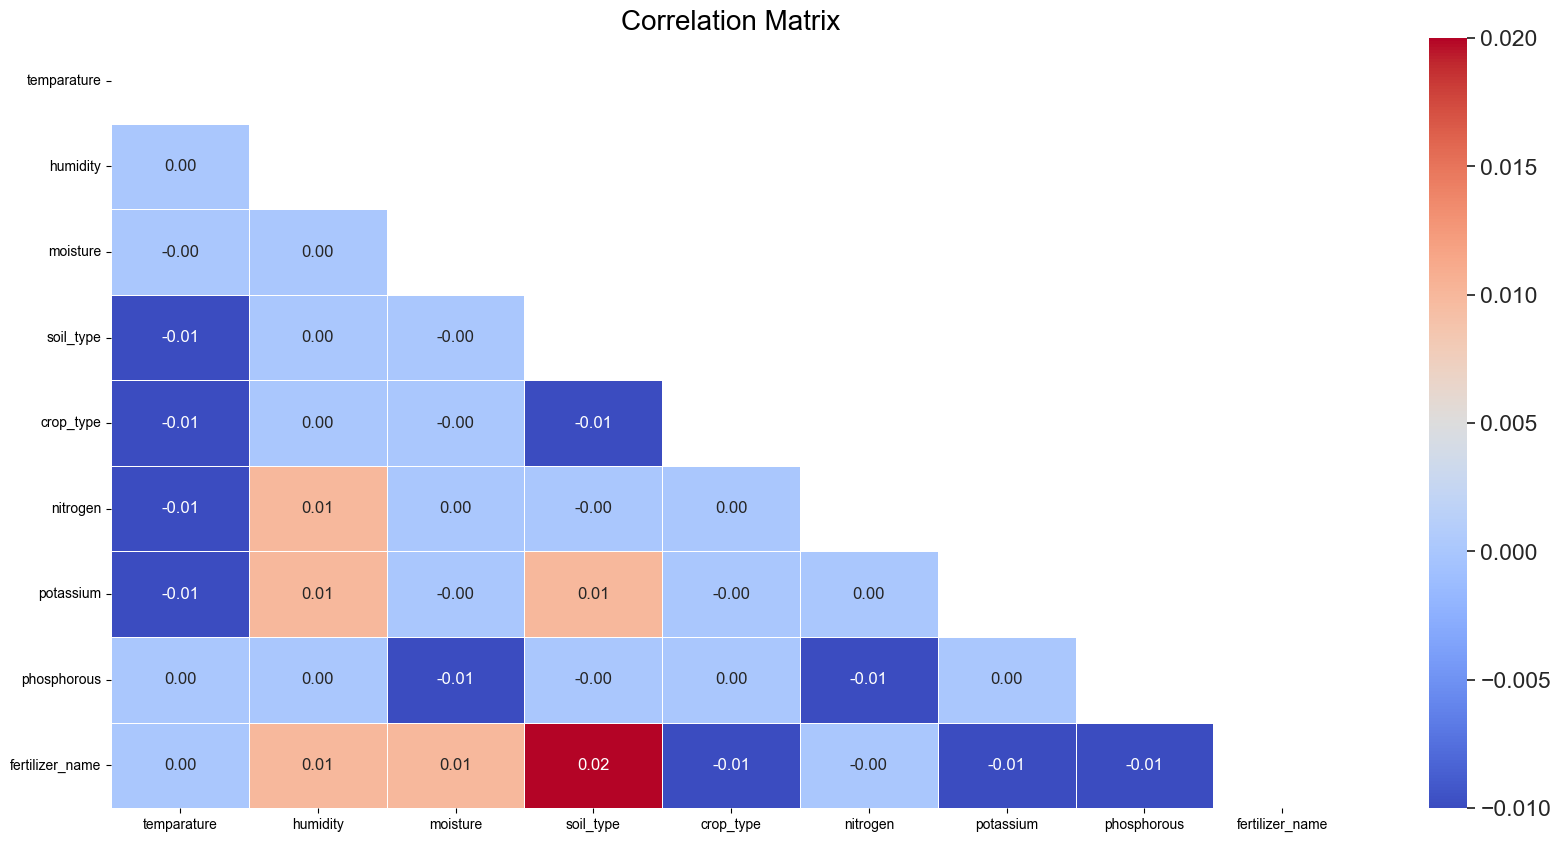

In [7]:
num_corr = round(train_df.corr(), 2)

# Correlation Matrix-Heatmap Plot
mask = np.zeros_like(num_corr)
mask[np.triu_indices_from(mask)] = True # optional, to hide repeat half of the matrix

f, ax = plt.subplots(figsize=(20, 10))
sns.set_theme(font_scale=1.5) # increase font size

ax = sns.heatmap(num_corr, mask=mask, annot=True, annot_kws={"size": 12}, linewidths=.5, cmap="coolwarm", fmt=".2f", ax=ax) # round to 2 decimal places
ax.set_title("Correlation Matrix", fontsize=20) # add title
plt.show()

On the first notebook I saw with the permutation importance that the less important features to the models are temperature, humidity, soil_type and potassium.

I'm going to have these features removed ad train the model while comparing with the baseline results.

In [8]:
features_removed = ['temparature', 'humidity', 'soil_type', 'potassium']

train_df = train_df.drop(columns= features_removed)

In [9]:
train_df

,moisture,crop_type,nitrogen,phosphorous,fertilizer_name
0,36,8,36,5,4
1,65,4,30,18,4
2,32,4,24,16,2
3,54,0,39,4,0
4,43,6,37,16,5
...,...,...,...,...,...
749995,30,3,8,6,4
749996,58,8,38,20,2
749997,59,2,6,29,0
749998,29,1,9,12,3


## Models after removing features

In [15]:
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, f1_score
from sklearn.preprocessing import StandardScaler

In [11]:
#classification issues
def train_and_eval_models(X_train, X_test, y_train, y_test):

    #models to test
    models = {
        "Logistic Regression" : LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000),
        "Random Forest" : RandomForestClassifier(),
        "XGB" : XGBClassifier()
    }

    print("Starting the training process.")

    #list to store results

    results = []

    #scaling data just for LogisticRegression

    for name, model in models.items():
        if name in ['Logistic Regression']:
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)
            print(f"Features scaled for model {name}")

        print(f"Training model: {name}")

        model.fit(X_train_scaled, y_train)

        y_train_predict = model.predict(X_train_scaled) #to test accuracy on the train dataframe
        y_test_predict = model.predict(X_test_scaled)

        results.append({
            "Model" : name,
            "Train Accuracy" : accuracy_score(y_train, y_train_predict),
            "Test Accuracy" : accuracy_score(y_test, y_test_predict),
            "Train Precision" : precision_score(y_train, y_train_predict, average = 'weighted'),
            "Test Precision" : precision_score(y_test, y_test_predict, average = 'weighted'),
            "Train F1 Score" : f1_score(y_train, y_train_predict, average = 'weighted'),
            "Test F1 Score" : f1_score(y_test, y_test_predict, average = 'weighted')
        })

    #Convering result into a df
    results_df = pd.DataFrame(results)
    print("\n Model Performance Summary: ")
    print(results_df)
    

    return results_df


In [13]:
from sklearn.model_selection import train_test_split

X = train_df.drop(columns='fertilizer_name')
y = train_df['fertilizer_name']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, random_state= 42)

In [16]:
results_df = train_and_eval_models(X_train, X_test, y_train, y_test)

Starting the training process.
Features scaled for model Logistic Regression
Training model: Logistic Regression
Training model: Random Forest
Training model: XGB

 Model Performance Summary: 
                 Model  Train Accuracy  Test Accuracy  Train Precision  \
0  Logistic Regression        0.155779       0.156182         0.116505   
1        Random Forest        0.756423       0.155769         0.756411   
2                  XGB        0.226587       0.184702         0.228139   

   Test Precision  Train F1 Score  Test F1 Score  
0        0.118642        0.118135       0.118695  
1        0.155601        0.756398       0.155671  
2        0.183740        0.221528       0.179809  


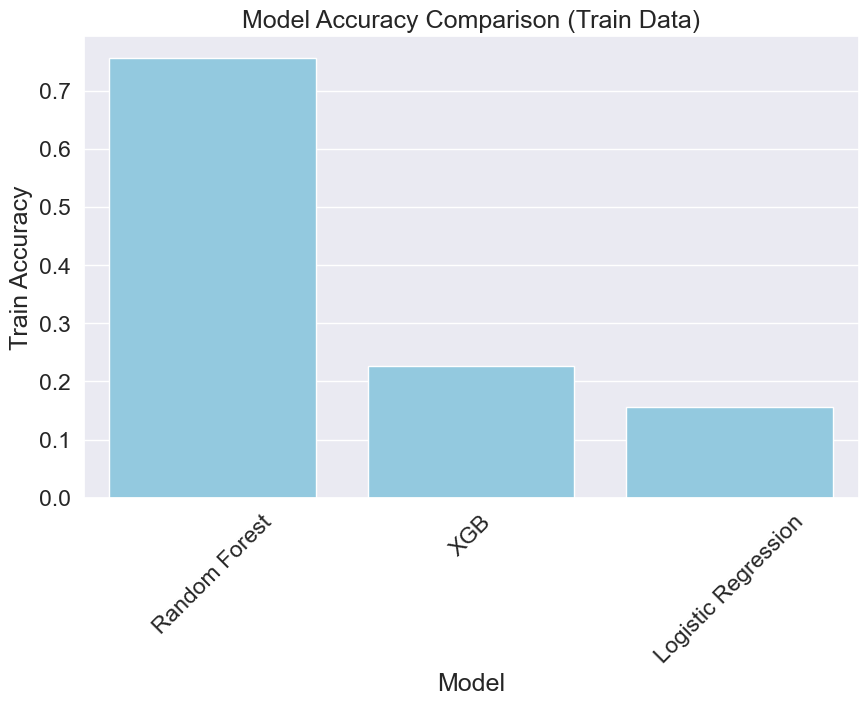

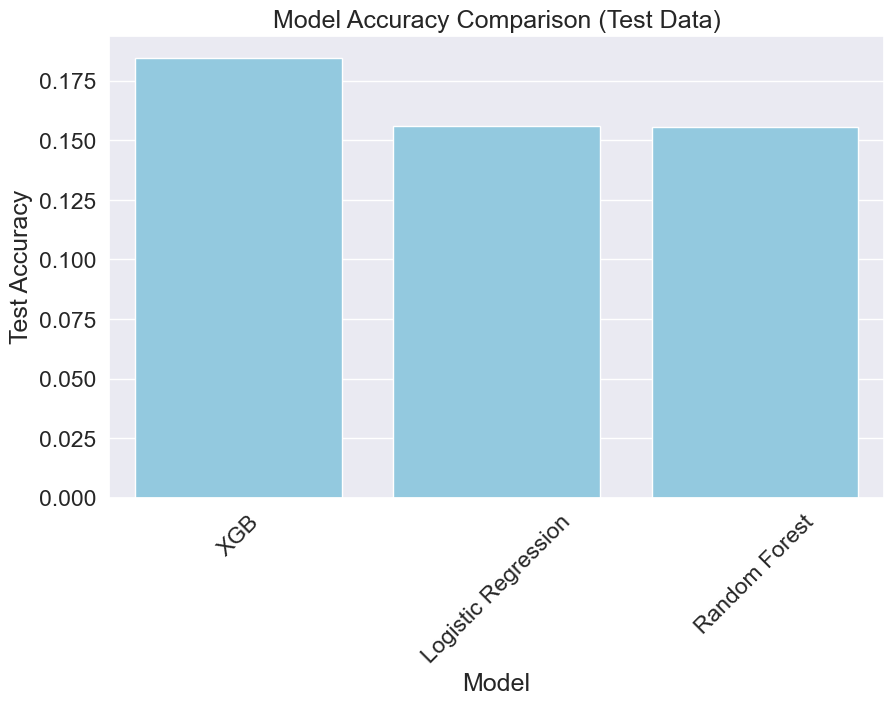

In [17]:
#plotting the results

plt.figure(figsize=(10, 6))
sns.barplot(x="Model", y="Train Accuracy", data=results_df.sort_values(by='Train Accuracy', ascending=False), color='skyblue')
plt.title("Model Accuracy Comparison (Train Data)")
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x="Model", y="Test Accuracy", data=results_df.sort_values(by='Test Accuracy', ascending=False), color='skyblue')
plt.title("Model Accuracy Comparison (Test Data)")
plt.xticks(rotation=45)
plt.show()